In [1]:
%matplotlib inline    
import datacube       # Truy xuất và phân tích dữ liệu địa cầu từ các nguồn dữ liệu không gian, pip install datacube
import sys            # Cung cấp các biến và chức năng liên quan đến hệ thống
import math           # Hàm và hằng số toán học
import pandas as pd   # Phân tích dữ liệu và làm việc với dữ liệu dạng bảng, pip install pandas
import numpy as np    # Tính toán khoa học và toán học trên mảng đa chiều, pip install numpy
import xarray as xr   # Phân tích và làm việc với dữ liệu dạng mảng đa chiều, pip install xarray
import matplotlib.pyplot as plt      # Hiển thị các đồ thị matplotlib, pip install matplotlib
from datacube.utils import masking   # Hỗ trợ tạo và áp dụng các mặt nạ (mask) trên dữ liệu

from odc.algo import mask_cleanup, erase_bad, to_f32
from deafrica_tools.plotting import rgb  # Bộ công cụ làm việc với dữ liệu địa lý của (Digital Earth Africa), pip install deafrica_tools
from deafrica_tools.plotting import display_map

ModuleNotFoundError: No module named 'datacube'

In [ ]:
dc = datacube.Datacube(app="ls8_sr_BenTre")  # Tạo một đối tượng Datacube từ module datacube

In [ ]:
# Lấy thông tin về các đại lượng đo lường của sản phẩm "ls8_sr"
productA = "ls8_sr"
measurements = dc.list_measurements()
measurements.loc[productA]

In [ ]:
datasets = dc.find_datasets(product='ls8_sr')

datasets

In [5]:
# Đặt truy vấn cho khu vực tỉnh Bến tre
lon = (105.9500000, 106.8000000) # Định vị kinh độ (longitude)
lat = (10.3333000, 9.8000000)    # Định vị vĩ độ (latitude)

query = {
    "x": lon,
    "y": lat,
    "time": ("2023-05-01", "2023-05-31")
}    # Truy vấn được xác định giới hạn kinh độ (x) là lon, giới hạn vĩ độ (y) là lat, và trong khoảng thời gian (time)

display_map(x=lon, y=lat) # hiển thị một bản đồ với khu vực địa lý


C:\Program Files\Python39\lib\site-packages\deafrica_tools\plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


In [8]:
# Truy xuất dữ liệu địa cầu từ một sản phẩm "ls8_sr" và chỉ định các đại lượng đo lường (measurements) cần quan tâm.
brands=['coastal_aerosol', 'red', 'green', 'blue', 'swir_1', 'swir_2', 'nir', 'pixel_quality', 'radsat', 'qa_aerosol']
ds = dc.load(product="ls8_sr",
             measurements=brands,
             output_crs="EPSG:32648", 
             resolution=(-250, 250), 
             align=(15, 15),
             **query
             )

In [9]:
ds

<xarray.Dataset>
Dimensions:          (time: 1, y: 239, x: 375)
Coordinates:
  * time             (time) datetime64[ns] 2023-05-06T03:13:39.281227
  * y                (y) float64 1.143e+06 1.143e+06 ... 1.084e+06 1.083e+06
  * x                (x) float64 6.039e+05 6.041e+05 ... 6.971e+05 6.974e+05
    spatial_ref      int32 32648
Data variables:
    coastal_aerosol  (time, y, x) uint16 9043 8968 8919 8900 8826 ... 0 0 0 0 0
    red              (time, y, x) uint16 10005 10085 9894 9995 9689 ... 0 0 0 0
    green            (time, y, x) uint16 10496 10478 10352 10385 ... 0 0 0 0
    blue             (time, y, x) uint16 9358 9346 9274 9282 9120 ... 0 0 0 0 0
    swir_1           (time, y, x) uint16 14197 14041 13260 13272 ... 0 0 0 0
    swir_2           (time, y, x) uint16 11286 11339 10813 10917 ... 0 0 0 0
    nir              (time, y, x) uint16 19554 18747 18134 17439 ... 0 0 0 0
    pixel_quality    (time, y, x) uint16 22080 21824 21824 21762 ... 1 1 1 1
    radsat           (time, y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    qa_aerosol       (time, y, x) uint8 224 224 130 160 96 130 ... 1 1 1 1 1 1
Attributes:
    crs:           epsg:32648
    grid_mapping:  spatial_ref

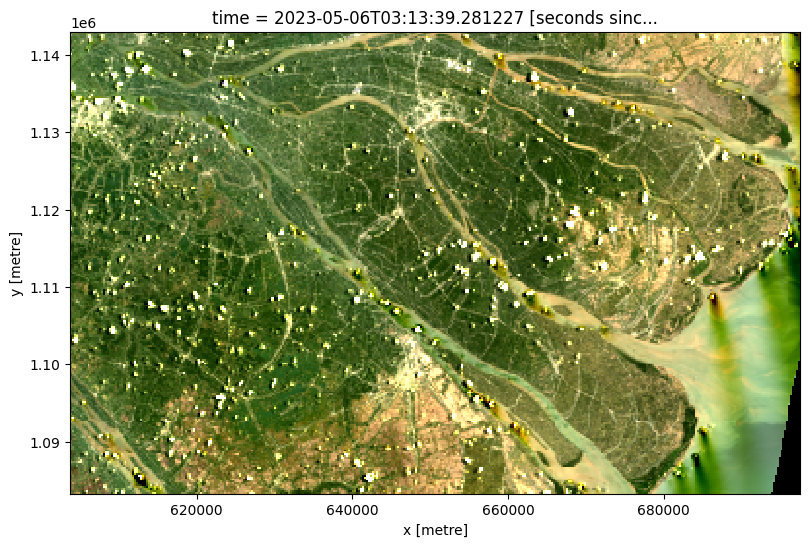

In [10]:
rgb(ds, index=0) # Tạo ra một ảnh màu sắc từ dữ liệu địa cầu được truy xuất (ds)

In [11]:
# Xác định và tạo một mặt nạ (mask) đám mây từ dữ liệu "pixel_quality" trong dữ liệu địa cầu

flags_def = ds["pixel_quality"].attrs["flags_definition"]

quality_flags = dict(
                cloud="high_confidence", # True là nơi có mây
                cirrus="high_confidence",# True là nơi có mây ti
                cloud_shadow="high_confidence",# True là nơi có bóng mây
) 

# Đặt cloud_mask: True=cloud, False=non-cloud
mask, _= masking.create_mask_value(flags_def, **quality_flags)

# Thêm mặt nạ đám mây (cloud_mask) vào tập dữ liệu
ds['cloud_mask'] = (ds['pixel_quality'] & mask) != 0

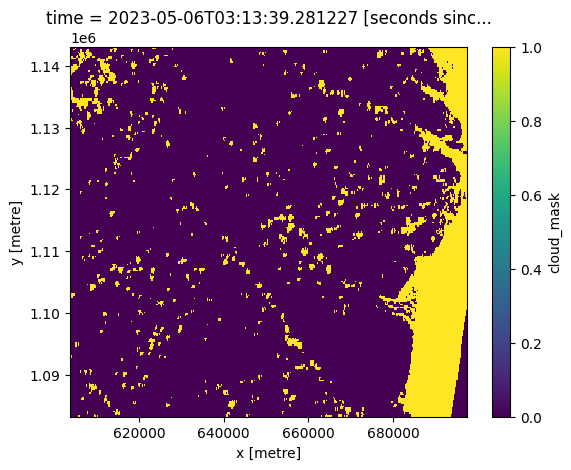

In [24]:
ds['cloud_mask'].plot(); # Hiển thị biểu đồ hoặc hình ảnh của mặt nạ đám mây (cloud_mask) trong tập dữ liệu địa cầu (ds).

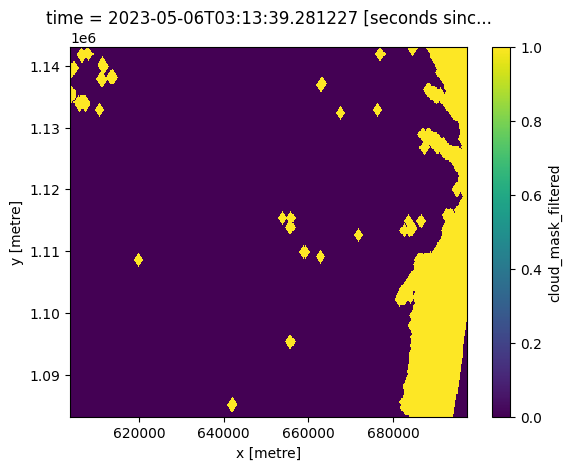

In [25]:
# Áp dụng các bộ lọc (filters) lên mặt nạ đám mây (cloud_mask) trong tập dữ liệu địa cầu (ds) 

filters = [("opening", 2),("dilation", 2)] # Các số nguyên đề cập đến số lượng pixel

# Sử dụng hàm mask_cleanup để áp dụng các bộ lọc
ds['cloud_mask_filtered'] = mask_cleanup(ds['cloud_mask'], mask_filters=filters)

# Plot kết quả
ds['cloud_mask_filtered'].plot()

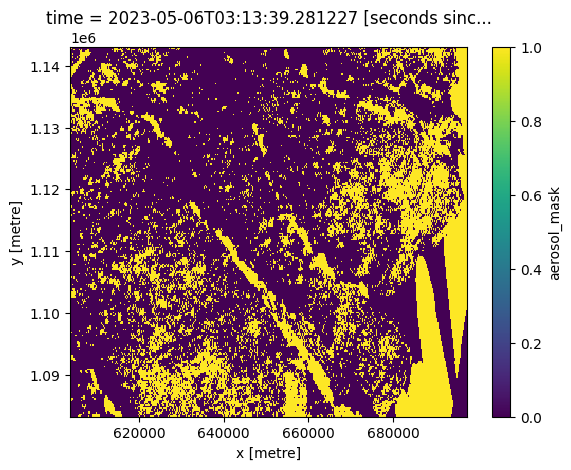

In [26]:
# Tạo một mặt nạ (mask) dựa trên các cờ (flags) trong đại lượng "qa_aerosol" trong tập dữ liệu địa cầu (ds)

aerosol_flags = ds.qa_aerosol.attrs["flags_definition"] # Tìm các cờ mặt nạ bit

# Tạo một lệnh cờ mà chúng tôi muốn che dấu
aerosol_quality_flags = dict(
    aerosol_level="high",
)

# tạo mặt nạ boolean trong đó high-aerosol = True
ds['aerosol_mask'] = masking.make_mask(ds['qa_aerosol'], **aerosol_quality_flags)

ds['aerosol_mask'].plot()

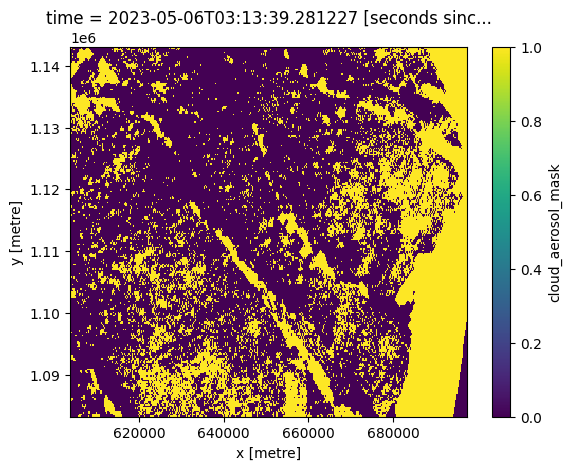

In [27]:
# Tạo một mặt nạ (mask) kết hợp từ hai mặt nạ khác nhau, (aerosol_mask) và (cloud_mask_filtered)
ds['cloud_aerosol_mask'] = ds['aerosol_mask'] | ds['cloud_mask_filtered']

# Plot kết quả
ds['cloud_aerosol_mask'].plot();

In [28]:
# xóa pixel bằng cloud
clear = erase_bad(ds.drop_vars(['cloud_mask_filtered', 'cloud_mask', 'cloud_aerosol_mask', 'aerosol_mask']),
                  ds['cloud_mask'])

# xóa pixel bằng cloud_filtering
clear_filtered = erase_bad(ds.drop_vars(['cloud_mask_filtered', 'cloud_mask', 'cloud_aerosol_mask','aerosol_mask']),
                           ds['cloud_mask_filtered'])

# xóa pixel bằng cloud and high aerosol
clear_filtered_aerosol = erase_bad(ds.drop_vars(['cloud_mask_filtered', 'cloud_mask', 'cloud_aerosol_mask','aerosol_mask']),
                          ds['cloud_aerosol_mask'])

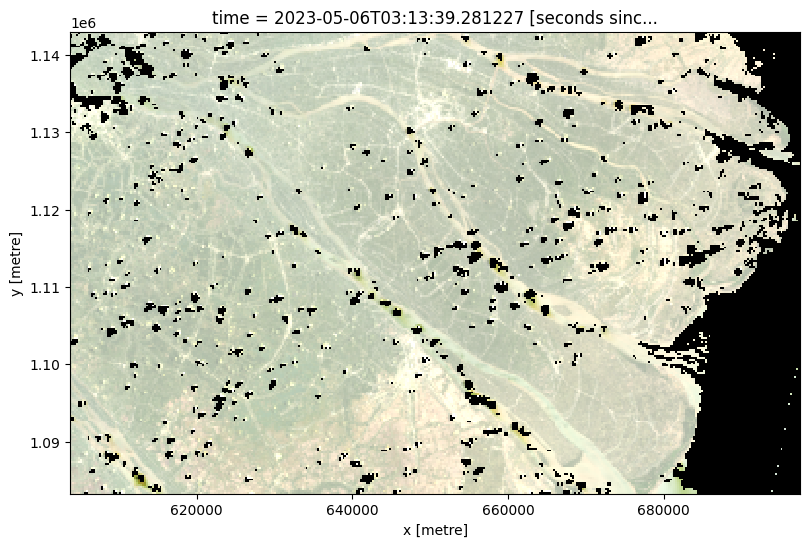

In [29]:
rgb(clear, index=0)

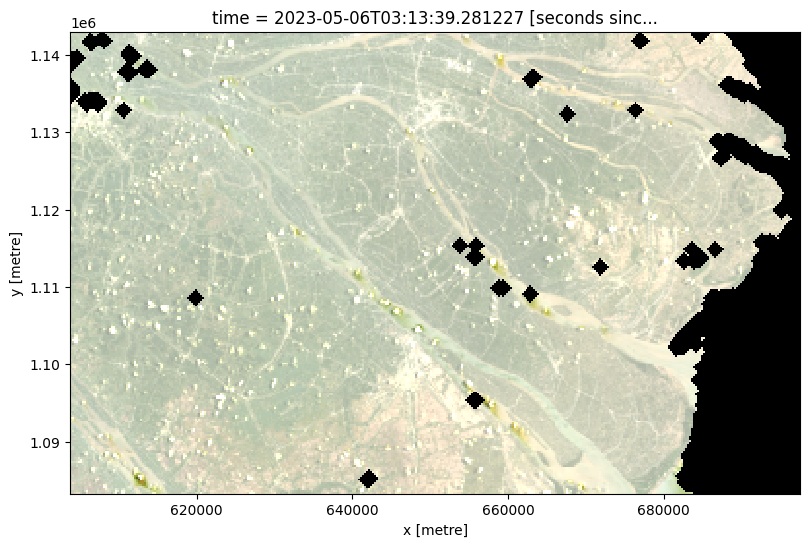

In [30]:
rgb(clear_filtered, index=0)

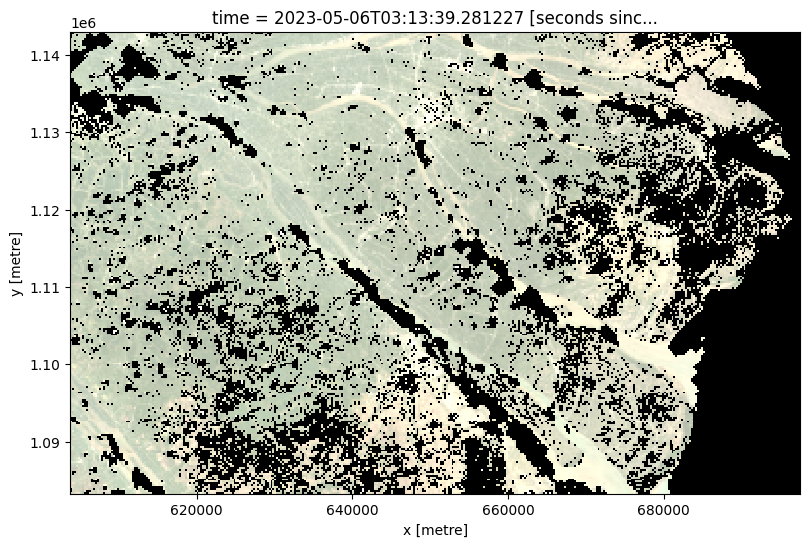

In [31]:
rgb(clear_filtered_aerosol, index=0)

C:\Program Files\Python39\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


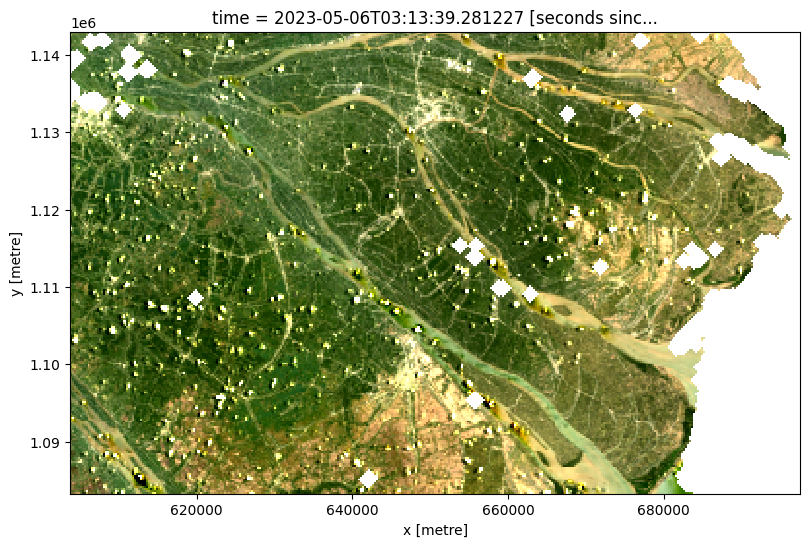

In [32]:
# Áp dụng các hệ số tỷ lệ và độ lệch cho dữ liệu của từng band cho dữ liệu Landsat

clear_filtered = to_f32(clear_filtered)  # Chuyển đổi dữ liệu thành `float32` và đặt giá trị no-data thành NaN

sr_bands = ["blue", "green", "red"]

for band in sr_bands:
    clear_filtered[band] = 2.75e-5 * clear_filtered[band] - 0.2
    
rgb(clear_filtered, index=0)

Khoảng giá trị của NDVI:
Minimum: -0.1381920550516109
Maximum: 0.46519943283398063


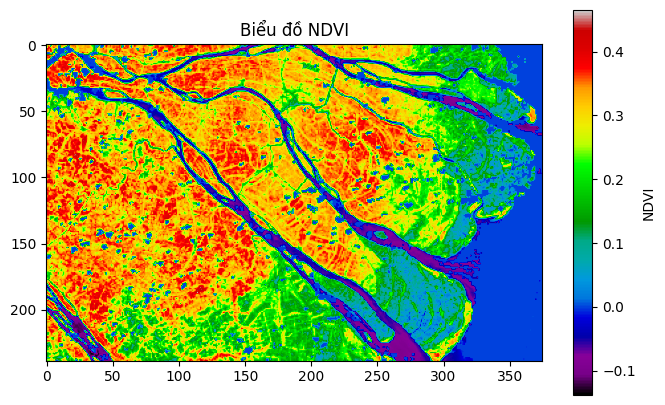

In [33]:
# Tính NDVI từ dữ liệu ảnh
red = clear["red"].values.astype(float)
nir = clear["nir"].values.astype(float)
ndvi = np.divide((nir - red), (nir + red), out=np.zeros_like(nir), where=(nir + red) != 0)

# In ra khoảng giá trị của NDVI
print("Khoảng giá trị của NDVI:")
print("Minimum:", np.nanmin(ndvi))
print("Maximum:", np.nanmax(ndvi))
# Vẽ đồ thị
# Reshape NDVI thành ma trận 2D (nếu cần thiết)
# ndvi_2d = ndvi.reshape((image_height, image_width))

# Vẽ đồ thị
plt.figure(figsize=(8, 5))
plt.imshow(ndvi.squeeze(), cmap='nipy_spectral')
plt.colorbar(label='NDVI')
plt.title('Biểu đồ NDVI')
plt.show()

Phân loại cây trồng theo khoảng giá trị NDVI:
Khoảng 1
  Đầu: -0.1382
  Cuối: -0.0175
  Số lượng giá trị: 5766
  Loại cây trồng: A
Khoảng 2
  Đầu: -0.0175
  Cuối: 0.1031
  Số lượng giá trị: 19274
  Loại cây trồng: B
Khoảng 3
  Đầu: 0.1032
  Cuối: 0.2238
  Số lượng giá trị: 15158
  Loại cây trồng: C
Khoảng 4
  Đầu: 0.2239
  Cuối: 0.3445
  Số lượng giá trị: 32781
  Loại cây trồng: D


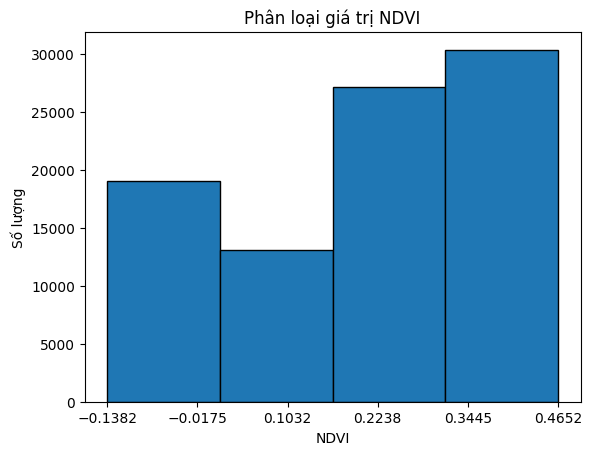

In [38]:
# Phân loại cây trồng dựa trên giá trị NDVI và hiển thị thông tin phân loại cây trồng và biểu đồ histogram tương ứng.

filtered_ndvi = ndvi[~np.isnan(ndvi)] # Lọc các giá trị không phải NaN

sorted_ndvi = np.sort(filtered_ndvi)  # Sắp xếp các giá trị
 
bins = np.linspace(np.nanmin(sorted_ndvi), np.nanmax(sorted_ndvi), 6)  # Chia ra 5 khoảng
digitized = np.digitize(sorted_ndvi, bins)

plant_types = ['A', 'B', 'C', 'D']  # Định nghĩa các cây trồng

print("Phân loại cây trồng theo khoảng giá trị NDVI:")  # In thông tin
for i in range(1, 5):
    values_in_bin = sorted_ndvi[digitized == i]
    num_values = len(values_in_bin)
    plant_type = plant_types[i-1]
    print("Khoảng", i)
    print("  Đầu:", round(values_in_bin[0], 4))
    print("  Cuối:", round(values_in_bin[-1], 4))
    print("  Số lượng giá trị:", num_values)
    print("  Loại cây trồng:", plant_type)

plt.hist(filtered_ndvi, bins=4, edgecolor='black')  # Vẽ biểu đồ histogram
plt.xlabel('NDVI')
plt.ylabel('Số lượng')
plt.title('Phân loại giá trị NDVI')
plt.xticks(bins)
plt.show()


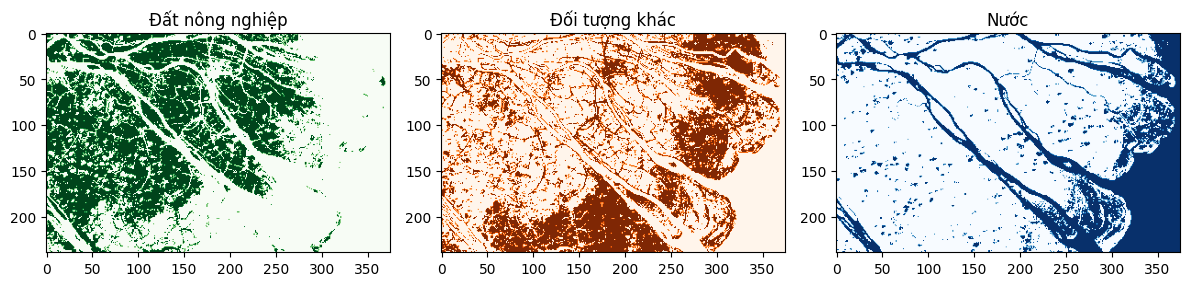

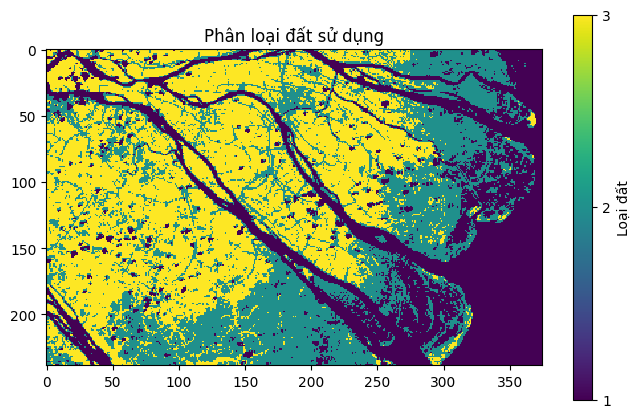

In [35]:
# Thực hiện phân loại các loại đất dựa trên chỉ số NDVI và hiển thị kết quả phân loại bằng các hình ảnh.

def classify_land_type(ndvi):
    agricultural_threshold = 0.3  # Ngưỡng cho đất nông nghiệp
    construction_threshold = 0.1  # Ngưỡng cho đối tượng khác

    agricultural_land = np.where(ndvi > agricultural_threshold, 1, 0)
    construction_area = np.where((ndvi <= agricultural_threshold) & (ndvi > construction_threshold), 1, 0)
    water = np.where(ndvi <= construction_threshold, 1, 0)

    return agricultural_land, construction_area, water


agricultural_land, construction_area, water = classify_land_type(ndvi)

# Thay đổi hình dạng của các lớp để loại bỏ kích thước đầu tiên
agricultural_land = agricultural_land.squeeze()
construction_area = construction_area.squeeze()
water = water.squeeze()

# Hiển thị kết quả phân loại
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(agricultural_land, cmap='Greens')
ax1.set_title('Đất nông nghiệp')
ax2.imshow(construction_area, cmap='Oranges')
ax2.set_title('Đối tượng khác')
ax3.imshow(water, cmap='Blues')
ax3.set_title('Nước')
plt.tight_layout()
plt.show()

# Gom lại các hình ảnh phân loại thành một hình duy nhất
combined_image = np.zeros_like(agricultural_land)
combined_image[np.where(water == 1)] = 1
combined_image[np.where(construction_area == 1)] = 2
combined_image[np.where(agricultural_land == 1)] = 3

# Hiển thị hình ảnh phân loại gom lại thành một hình duy nhất
plt.figure(figsize=(8, 5))
plt.imshow(combined_image, cmap='viridis', interpolation='none')
plt.colorbar(ticks=[1, 2, 3], label='Loại đất')
plt.title('Phân loại đất sử dụng')
plt.show()

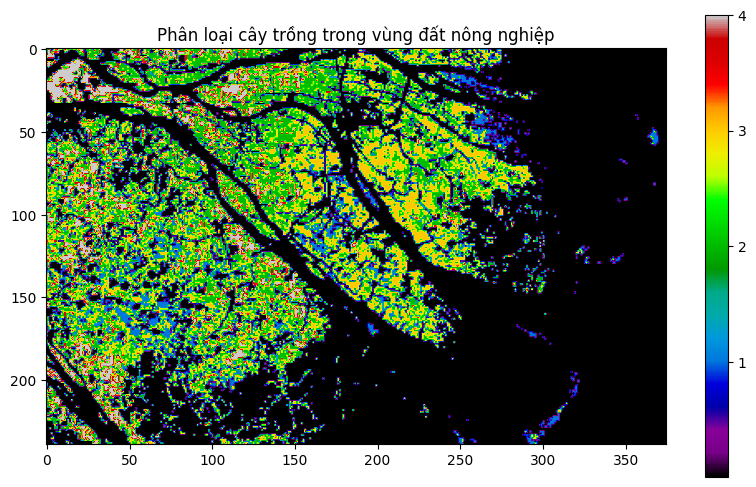

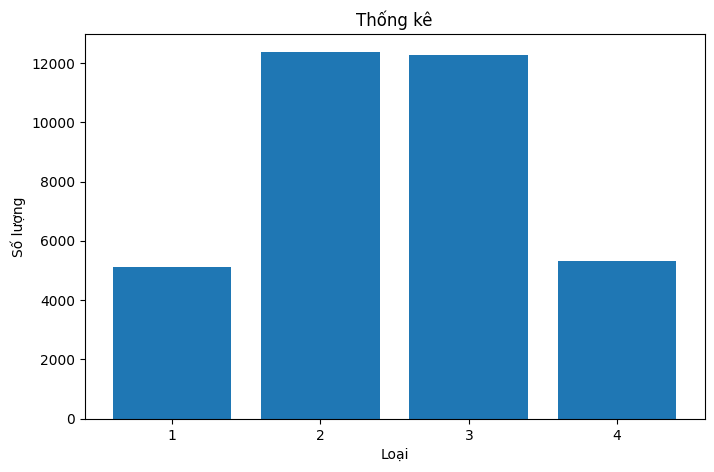

In [37]:
from sklearn.cluster import KMeans

# Tạo mặt nạ (mask) chỉ với các vùng NDVI lớn hơn hoặc bằng 0.3
mask = ndvi >= 0.3

# Áp dụng thuật toán K-means clustering cho các vùng thỏa mãn mặt nạ
masked_red = red[mask]
masked_nir = nir[mask]
masked_ndvi = ndvi[mask]

# Chuẩn bị dữ liệu đầu vào cho phân đoạn đa lớp
input_data = np.column_stack((masked_red, masked_nir, masked_ndvi))

# Áp dụng thuật toán K-means clustering để phân chia thành các lớp
num_classes = 4  # Số lượng lớp muốn phân chia
kmeans = KMeans(n_clusters=num_classes, random_state=0, n_init=4).fit(input_data)
labels = kmeans.labels_

# Tạo mặt nạ phân chia từ mặt nạ ban đầu
segmentation_mask = np.zeros_like(ndvi, dtype=np.uint8)
segmentation_mask_2d = np.squeeze(segmentation_mask)

segmentation_mask[mask] = labels + 1  # Gán nhãn lớp (từ 1 đến num_classes)

# Đếm số lượng điểm dữ liệu trong mỗi lớp
class_counts = np.bincount(labels)
num_classes = len(class_counts)

# Hiển thị theo dạng hình ảnh
plt.figure(figsize=(10, 6))
plt.imshow(segmentation_mask_2d, cmap='nipy_spectral')
plt.colorbar(ticks=range(1, num_classes + 1))
plt.title('Phân loại cây trồng trong vùng đất nông nghiệp')
plt.show()

# Hiển thị theo dạng biểu đồ
plt.figure(figsize=(8, 5))
x_values = np.arange(1, num_classes + 1)  # Tạo một mảng từ 1 đến num_classes
plt.bar(x_values, class_counts)
plt.xlabel('Loại')
plt.ylabel('Số lượng')
plt.title('Thống kê')
plt.xticks(x_values)  # Đặt các nhãn trục x cho từng giá trị từ 1 đến num_classes
plt.show()